In [1]:
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import wandb

# set random seed
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

tf.compat.v1.disable_eager_execution()

# Initializing wandb functionality

In [2]:
!wandb login --relogin
# Copy and paste this api key: 822244d22c29151b0b6501c81c4e22a5c5a0843f

entity_name="vamsi_malineni6"
project_name="bc_pinn_ltd_1data_longer_training"

wandb.init(entity=entity_name,project=project_name)
# Finish the dummy run started after first initializing
wandb.run.finish()

# # Delete the dummy run from the wandb workspace 
# api=wandb.Api()
# run_id=wandb.run.id
# run=ap.run(str(entity_name)+"/"+str(project_name)+"/"+str(run_id))
# run.delete()

'wandb' is not recognized as an internal or external command,
operable program or batch file.
wandb: Currently logged in as: vamsi_malineni6. Use `wandb login --relogin` to force relogin


In [2]:
class bc_pinn_t0:
    # Initialize the class
    def __init__(self,domain,initial,boundary,domaindata,datalist,
                 ntrain,batch_size,layers,re,
                 load_model=False,filedr='',freeze=0,timestep=0,
                 savewandb='',saveloss=''):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        self.datalist = datalist
        self.domain_data = domaindata
        
        self.freeze   = freeze
        self.time_step = timestep
        
        self.params_name = savewandb
        self.loss_name   = saveloss
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.xa=self.domain[:,0].reshape(self.domain[:,0].shape[0],1)
        self.ya=self.domain[:,1].reshape(self.domain[:,1].shape[0],1)
        self.ta=self.domain[:,2].reshape(self.domain[:,2].shape[0],1)
        self.ua=self.domain[:,3].reshape(self.domain[:,3].shape[0],1)
        self.va=self.domain[:,4].reshape(self.domain[:,4].shape[0],1)
        
        
        X = np.concatenate([self.xa,self.ya,self.ta], 1)

        self.lowb = X.min(0) 
        self.upb = X.max(0)
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=self.initial[:,0].reshape(self.initial[:, 0].shape[0], 1)
        self.y0=self.initial[:,1].reshape(self.initial[:, 1].shape[0], 1)
        self.t0=self.initial[:,2].reshape(self.initial[:, 2].shape[0], 1)
        self.u0=self.initial[:,3].reshape(self.initial[:, 3].shape[0], 1)
        self.v0=self.initial[:,4].reshape(self.initial[:, 4].shape[0], 1)
        
        self.xb=self.boundary[:,0].reshape(self.boundary[:, 0].shape[0], 1)
        self.yb=self.boundary[:,1].reshape(self.boundary[:, 1].shape[0], 1)
        self.tb=self.boundary[:,2].reshape(self.boundary[:, 2].shape[0], 1)
        self.ub=self.boundary[:,3].reshape(self.boundary[:, 3].shape[0], 1)
        self.vb=self.boundary[:,4].reshape(self.boundary[:, 4].shape[0], 1)
        
  
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers,self.freeze)
            
        

        # tf placeholders and graph
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        
        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        # Domain data placeholders 
        self.xdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.ydata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.tdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        self.udata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ua.shape[1]])
        self.vdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.va.shape[1]])
        
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        # Domain data predictions
        self.u_dom_pred,self.v_dom_pred,_=\
            self.net_NS(self.xdata_tf,self.ydata_tf,self.tdata_tf)
        
        # Domain predictions
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        alpha, beta = 1, 1

        # set loss function
        self.initial_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred))
        
        self.boundary_loss = beta * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred))

        self.domdata_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.udata_tf - self.u_dom_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.vdata_tf - self.v_dom_pred))

        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))

        
        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.domdata_loss
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
        self.loss_d=[]

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
                       
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers,freeze):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable, with few of the layers frozen for trainin
        for num in range(0,num_layers-1):
            if num<freeze:
                tf_weights.append ( tf.Variable (weights[num],trainable ='False'))
                tf_biases.append  ( tf.Variable (biases[num],trainable ='False'))
            else:
                tf_weights.append ( tf.Variable (weights[num],trainable ='True'))
                tf_biases.append  ( tf.Variable (biases[num],trainable ='True' ))
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    
#===========================================================================================================#
#========================================saving loss values=================================================#
#===========================================================================================================#
    def save_loss(self,fileDr,tf_dict):
        self.loss_i.append(self.sess.run(self.initial_loss,tf_dict))
        self.loss_b.append(self.sess.run(self.boundary_loss,tf_dict))
        self.loss_r.append(self.sess.run(self.residual_loss,tf_dict))
        self.loss_d.append(self.sess.run(self.domdata_loss,tf_dict))
                       
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([self.loss_i,self.loss_b,self.loss_r,self.loss_d],f)
            print("Loss are saved in pickle file")
    
    def load_loss(self,fileDr):
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            initial,boundary,residual,datadomain=pickle.load(f)
        
        print("Losses are loaded successfully")
        
        return initial,boundary,residual,datadomain
    

    
#===========================================================================================================#
#===========================================================================================================#
#===========================================================================================================#
 

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.keras.activations.swish(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 

        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0] 

        f_u = u_t + (u * u_x + v * u_y) + p_x - (1/self.re) * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - (1/self.re) * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e

#===========================================================================================================#
#===========================Predicting and finding error every 10 epochs====================================#
#===========================================================================================================#
   
    
    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star
    
    def load_testdata(self,time_step):
        
        # Converting the time_step from decimal to integer 0.1 --> 1
        ts=int(10*time_step)

        # Loading the complete list of data 
        data_list=self.datalist

        # Extracting the data for the given range of time steps [0,0.1] and so on
        dt=0.1
        times=[round(i,3) for i in np.arange(0,7+dt,dt)]

        # Finding the indexes of initial and final timestep from the times list
        t1=times.index(round((time_step-1.0),2))
        t2=times.index(time_step)

        temp=[]
        # Excluding INITIAL DATA from the collocation points, to make sure that the model is not overfitting on
        # initial points, as there is u,v data available for the model. 

        for i in range(t1,t2+1):
            if i<t2+1:
                temp.append(data_list[i])

        # data stores the final timestep data for the given time segment

        data=np.concatenate(temp[4:],axis=0)

        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]

        return X_star,Y_star
    
    def find_error(self,test_time_step):
        
        X_star,Y_star=self.load_testdata(test_time_step)
        u_pred,_,_ = self.predict(X_star[0],X_star[1],X_star[2])
        
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        

        return error_u
        
#===========================================================================================================#
#===========================ADAM TRAINING FUNCTION==========================================================#
#===========================================================================================================#
   
#IMPORTANT NOTES for a given TIME SEGMENT consisting of (5*10000=50000) points in the grid.

# (1) Randomly sampling 1000 datapoints every iteration from 38416 collocation points
#     effectively per epoch the model would see 25000 collocation points, which is 65% of sampled colloc points

# (2) Randomly sampling 250 datapoints every iteration from 19208 data points,
#     effectively per epoch the model would see 6250 data points. which is 32% of the sampled data points
 
# (3) The model would see 10000 initial conditions data points per iteration per epoch
#
# (4) The model would see 1584 boundary conditions points per iteration per epoch


    def Adam_train(self, epoch=5000, learning_rate=1e-3):
    
        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                idx=  np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
                didx= np.random.choice(self.domain_data.shape[0],250,replace=False)
                
                self.data_domain=self.domain[idx,:]
                self.data_driven=self.domain_data[didx,:]
                
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                td=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)

                xdata=self.data_driven[:,0].reshape(self.data_driven[:, 0].shape[0], 1)
                ydata=self.data_driven[:,1].reshape(self.data_driven[:, 1].shape[0], 1)
                tdata=self.data_driven[:,2].reshape(self.data_driven[:, 2].shape[0], 1)
                udata=self.data_driven[:,3].reshape(self.data_driven[:, 3].shape[0], 1)
                vdata=self.data_driven[:,4].reshape(self.data_driven[:, 4].shape[0], 1)
                    
                Xd = np.concatenate([xd,yd,td], 1)
                
                # In contrast the model would see 10000 initial data points every iteration and every epoch
                # The model would see 1584 boundary conditions points every iteration and every epoch
                
                tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0, 
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.t_tf: td,
                           
                           self.xdata_tf: xdata, 
                           self.ydata_tf: ydata, 
                           self.tdata_tf: tdata,
                           self.udata_tf: udata,
                           self.vdata_tf: vdata,
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, tf_dict)
            
            if it % 10 == 0:
                
                elapsed = time.time() - start_time
                
                t_loss= self.sess.run(self.loss, tf_dict)
                i_loss= self.sess.run(self.initial_loss,tf_dict)
                b_loss= self.sess.run(self.boundary_loss,tf_dict)
                r_loss= self.sess.run(self.residual_loss,tf_dict)
                d_loss= self.sess.run(self.domdata_loss,tf_dict)
                
                # Saving the loss values in a pickle file
#                 self.save_loss(self.loss_name,tf_dict)
                
                # Finding the error value at given timestep for every 10 epochs
                eu1= self.find_error(1)
                eu2= self.find_error(2)
                eu3= self.find_error(3)
                eu4= self.find_error(4)
                eu5= self.find_error(5)
                eu6= self.find_error(6)
                eu7= self.find_error(7)
                
                # Logging the loss values and error values to wandb workspace:
                log_dict={"Total_loss":t_loss,"Initial_loss":i_loss,\
                         "Boundary_loss":b_loss,"Residual_loss":r_loss,\
                         "Data_loss":d_loss,\
                         "time step 1":eu1,\
                         "time step 2":eu2,\
                         "time step 3":eu3,\
                         "time step 4":eu4,\
                         "time step 5":eu5,\
                         "time step 6":eu6,\
                         "time step 7":eu7
                         }
                         
                
                wandb.log(log_dict)
                
                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, t_loss, elapsed))
                
                start_time = time.time()
            
            if it % 1000 == 0 and it > 0:
                self.save_parameters(self.params_name)
                




# This code snippet is for training for timesegments other than initial one

In [3]:
class bc_pinn_t:
    # Initialize the class
    def __init__(self,domain,initial,boundary,domaindata,prevtimedata,datalist,
                 ntrain,batch_size,layers,re,
                 load_model=False,filedr='',freeze=0,timestep=0
                 ,savewandb='',saveloss=''):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        self.domain_data = domaindata
        self.prev_data = prevtimedata
        self.datalist = datalist
        
        self.freeze = freeze
        self.time_step = timestep
        
        self.params_name = savewandb
        self.loss_name   = saveloss
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        #=========================================================================================================#
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.xa=self.domain[:,0].reshape(self.domain[:,0].shape[0],1)
        self.ya=self.domain[:,1].reshape(self.domain[:,1].shape[0],1)
        self.ta=self.domain[:,2].reshape(self.domain[:,2].shape[0],1)
        self.ua=self.domain[:,3].reshape(self.domain[:,3].shape[0],1)
        self.va=self.domain[:,4].reshape(self.domain[:,4].shape[0],1)
        
        # This creates an array of collocation points only for the domain
        X = np.concatenate([self.xa,self.ya,self.ta], 1)
        self.lowb = X.min(0) 
        self.upb = X.max(0)
        
        #=========================================================================================================#
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=self.initial[:,0].reshape(self.initial[:, 0].shape[0], 1)
        self.y0=self.initial[:,1].reshape(self.initial[:, 1].shape[0], 1)
        self.t0=self.initial[:,2].reshape(self.initial[:, 2].shape[0], 1)
        self.u0=self.initial[:,3].reshape(self.initial[:, 3].shape[0], 1)
        self.v0=self.initial[:,4].reshape(self.initial[:, 4].shape[0], 1)
        
        self.xb=self.boundary[:,0].reshape(self.boundary[:, 0].shape[0], 1)
        self.yb=self.boundary[:,1].reshape(self.boundary[:, 1].shape[0], 1)
        self.tb=self.boundary[:,2].reshape(self.boundary[:, 2].shape[0], 1)
        self.ub=self.boundary[:,3].reshape(self.boundary[:, 3].shape[0], 1)
        self.vb=self.boundary[:,4].reshape(self.boundary[:, 4].shape[0], 1)
        
  
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers,self.freeze)
            
        

        # tf placeholders and graph
        
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        
        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        # Domain data placeholders 
        self.xdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.ydata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.tdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])
        
        self.udata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ua.shape[1]])
        self.vdata_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.va.shape[1]])
        
        # Previous timestep placeholders
        self.xtime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ytime_tf = tf.compat.v1.placeholder(tf.float32)
        self.ttime_tf = tf.compat.v1.placeholder(tf.float32)
        self.utime_tf = tf.compat.v1.placeholder(tf.float32)
        self.vtime_tf = tf.compat.v1.placeholder(tf.float32)
        
        
        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        # Domain data predictions
        self.u_dom_pred,self.v_dom_pred,_=\
            self.net_NS(self.xdata_tf,self.ydata_tf,self.tdata_tf)
        
        # Domain residual predictions
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)
        
        # Previous time step predictions
        self.u_time_pred,self.v_time_pred,_=\
            self.net_NS(self.xtime_tf,self.ytime_tf,self.ttime_tf)
        
        
        alpha, beta = 1, 1

        # set loss function
        self.initial_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred))
        
        self.boundary_loss = beta * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred))

        self.domdata_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.udata_tf - self.u_dom_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.vdata_tf - self.v_dom_pred))
        
        self.prevtime_loss = alpha * tf.reduce_mean(input_tensor=tf.square(self.utime_tf - self.u_time_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.vtime_tf - self.v_time_pred))
        
        
        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))

        
        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss + self.domdata_loss + self.prevtime_loss
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
        self.loss_d=[]
        self.loss_p=[]

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
                       
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers,freeze):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            if num<freeze:
                tf_weights.append ( tf.Variable (weights[num],trainable ='False'))
                tf_biases.append  ( tf.Variable (biases[num],trainable ='False'))
            else:
                tf_weights.append ( tf.Variable (weights[num],trainable ='True' ))
                tf_biases.append  ( tf.Variable (biases[num],trainable ='True' ))
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    
#===========================================================================================================#
#========================================saving loss values=================================================#
#===========================================================================================================#
    def save_loss(self,fileDr,tf_dict):
        self.loss_i.append(self.sess.run(self.initial_loss,tf_dict))
        self.loss_b.append(self.sess.run(self.boundary_loss,tf_dict))
        self.loss_r.append(self.sess.run(self.residual_loss,tf_dict))
        self.loss_d.append(self.sess.run(self.domdata_loss,tf_dict))
        self.loss_p.append(self.sess.run(self.prevtime_loss,tf_dict))
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([self.loss_i,self.loss_b,self.loss_r,self.loss_d,self.loss_p],f)
            print("Loss are saved in pickle file")
    
    def load_loss(self,fileDr):
        
        root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_params\novel_method\exp20")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            initial,boundary,residual,datadomain,prevtimeloss=pickle.load(f)
        
        print("Losses are loaded successfully")
        
        return initial,boundary,residual,datadomain,prevtimeloss
    
#===========================================================================================================#
#========================================Utility fucntions of NN============================================#
#===========================================================================================================#
 

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.keras.activations.swish(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 

        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0] 

        f_u = u_t + (u * u_x + v * u_y) + p_x - (1/self.re) * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - (1/self.re) * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e
    
#===========================================================================================================#
#===========================Predicting and finding error every 10 epochs====================================#
#===========================================================================================================#
   

    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star
    
    def load_testdata(self,time_step):
        
        # Converting the time_step from decimal to integer 0.1 --> 1
        ts=int(10*time_step)

        # Loading the complete list of data 
        data_list=self.datalist

        # Extracting the data for the given range of time steps [0,0.1] and so on
        dt=0.1
        times=[round(i,3) for i in np.arange(0,7+dt,dt)]

        # Finding the indexes of initial and final timestep from the times list
        t1=times.index(round((time_step-1.0),2))
        t2=times.index(time_step)

        temp=[]
        # Excluding INITIAL DATA from the collocation points, to make sure that the model is not overfitting on
        # initial points, as there is u,v data available for the model. 

        for i in range(t1,t2+1):
            if i<t2+1:
                temp.append(data_list[i])

        # data stores the final timestep data for the given time segment

        data=np.concatenate(temp[4:],axis=0)

        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]

        return X_star,Y_star
    
    def find_error(self,test_time_step):
        
        X_star,Y_star=self.load_testdata(test_time_step)
        u_pred,_,_ = self.predict(X_star[0],X_star[1],X_star[2])
        
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        

        return error_u
        
    
    
    
#===========================================================================================================#
#===========================ADAM TRAINING FUNCTION==========================================================#
#===========================================================================================================#

    def Adam_train(self, epoch=5000, learning_rate=1e-3):

        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                # Randomly sampling ntrain datapoints in the spatio-temporal region
                idx=  np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
                
                didx= np.random.choice(self.domain_data.shape[0],250,replace=False)
                
                # Should increase the batch size of prev data so that the model would be able to see more number of points
                # per iteration
                pidx= np.random.choice(self.prev_data.shape[0],1000,replace=False)
                
                self.data_domain = self.domain[idx,:]
                self.data_driven = self.domain_data[didx,:]
                self.prev_batch  = self.prev_data[pidx,:]
                
                # Collocation points inside the domain without data
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                td=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)
                
                # Collocation points inside the domain with data
                xdata=self.data_driven[:,0].reshape(self.data_driven[:, 0].shape[0], 1)
                ydata=self.data_driven[:,1].reshape(self.data_driven[:, 1].shape[0], 1)
                tdata=self.data_driven[:,2].reshape(self.data_driven[:, 2].shape[0], 1)
                udata=self.data_driven[:,3].reshape(self.data_driven[:, 3].shape[0], 1)
                vdata=self.data_driven[:,4].reshape(self.data_driven[:, 4].shape[0], 1)
                
                # Points from the previous time steps with data
                xprev=self.prev_batch[:,0].reshape(self.prev_batch[:,0].shape[0],1)
                yprev=self.prev_batch[:,1].reshape(self.prev_batch[:,1].shape[0],1)
                tprev=self.prev_batch[:,2].reshape(self.prev_batch[:,2].shape[0],1)
                uprev=self.prev_batch[:,3].reshape(self.prev_batch[:,3].shape[0],1)
                vprev=self.prev_batch[:,4].reshape(self.prev_batch[:,4].shape[0],1)
                
                Xd = np.concatenate([xd,yd,td], 1)
        
                tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0, 
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.t_tf: td,
                           
                           self.xdata_tf: xdata, 
                           self.ydata_tf: ydata, 
                           self.tdata_tf: tdata,
                           self.udata_tf: udata,
                           self.vdata_tf: vdata,
                           
                           self.xtime_tf: xprev,
                           self.ytime_tf: yprev,
                           self.ttime_tf: tprev,
                           self.utime_tf: uprev,
                           self.vtime_tf: vprev,
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, tf_dict)
            
            if it % 10 == 0:
                
                elapsed = time.time() - start_time
                
                t_loss= self.sess.run(self.loss, tf_dict)
                i_loss= self.sess.run(self.initial_loss,tf_dict)
                b_loss= self.sess.run(self.boundary_loss,tf_dict)
                r_loss= self.sess.run(self.residual_loss,tf_dict)
                d_loss= self.sess.run(self.domdata_loss,tf_dict)
                p_loss= self.sess.run(self.prevtime_loss,tf_dict)
                
                # Saving the loss values in a pickle file
#                 self.save_loss(self.loss_name,tf_dict)
                
                # Finding the error value at given timestep for every 10 epochs
                eu1= self.find_error(1)
                eu2= self.find_error(2)
                eu3= self.find_error(3)
                eu4= self.find_error(4)
                eu5= self.find_error(5)
                eu6= self.find_error(6)
                eu7= self.find_error(7)
#                 eo= self.find_error(0.1)
                
                # Logging the loss values and error values to wandb workspace:
                log_dict={"Total_loss":t_loss,"Initial_loss":i_loss,\
                         "Boundary_loss":b_loss,"Residual_loss":r_loss,\
                         "Data_loss":d_loss,"Previous_loss":p_loss,\
                          "time step 1":eu1,\
                          "time step 2":eu2,\
                          "time step 3":eu3,\
                          "time step 4":eu4,\
                          "time step 5":eu5,\
                          "time step 6":eu6,\
                          "time step 7":eu7
                         }
                
                wandb.log(log_dict)
                
                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, t_loss, elapsed))
                
                start_time = time.time()
            
            if it % 10 == 0 and it > 0:
                self.save_parameters(self.params_name)
                




# Data loading functions

In [4]:
def load_complete_data():

    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re100_data_true"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()
    
    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()
    
    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    time=pd.read_csv(path+r"/time.csv")
    time=time.to_numpy()
    time=time-time[0]

    N=xy.shape[0]
    TT = np.tile(time, (1,N)).T # N x T
    
    # stores the data for each time step as a list
    data_list=[]
    
    for i in range(TT.shape[1]):
        if i<N:
            t=TT[:,i:i+1]
            u=uvel[:,i:i+1]
            v=vvel[:,i:i+1]
            p=press[:,i:i+1]
            a=np.concatenate([xy,t,u,v,p],1)
            data_list.append(a)
    
    return data_list


In [5]:
def reduced_data(temp_datalist,min_max):
    
    xmax,xmin,ymax,ymin,tmax,tmin=min_max

    # Removing the boundary conditions 
    temp_data=[]
    for i in range(len(temp_datalist)):
        td=temp_datalist[i]
        td=td[:,:][td[:,0]>xmin]
        td=td[:,:][td[:,1]>ymin]
        td=td[:,:][td[:,0]<xmax]
        td=td[:,:][td[:,1]<ymax]
        temp_data.append(td)

    tot_num=temp_data[0].shape[0]
    # Choosing 1% of data 
    didx= np.random.choice(tot_num,int(tot_num/100),replace=False)

    data_datalist=[]
    for i in range(len(temp_data)):
        data_datalist.append(temp_data[i][didx,:])


    return data_datalist

In [6]:
def load_data(time_step):
    
    # Loading the complete list of data for all timesteps
    data_list=load_complete_data()
    
    # This creates a smaller dataset of timesteps untill 7 
    temp_datalist=[]
    for i in range(len(data_list)):
        if(np.unique(data_list[i][:,2])<7):
            temp_datalist.append(data_list[i])
        else:
            break
   

    
    # ================================================================================#
    # ================================================================================#
    # ================================================================================#

    # Should randomly sample from the above temp datalist 
    dt=0.1
    times=[round(i,3) for i in np.arange(0,7+dt,dt)]
    
    # Finding the indexes of initial and final timestep
    t1=times.index(round((time_step-1.0),2))
    t2=times.index(time_step)
    
    temp=[]
    for i in range(t1,t2+1):
        if i<t2+1:
            temp.append(temp_datalist[i])

    # data1 stores the initial time for the given timestep
    data1=temp[0]

    # data_b stores the data for boundary conditions
    data_b=np.concatenate(temp,axis=0)
    data_b=data_b[:,0:5]
    
    # data stores the collocation points inside the domain
    data=np.concatenate(temp[1:],axis=0)

    # Extracting x,y,t values from data
    xx=data_b[:,0:1]
    yy=data_b[:,1:2]
    tt=data_b[:,2:3]
    
    # Extracting unique values and there by maximum and minimum values of x 
    # and y
    ax=np.unique(xx)
    ay=np.unique(yy)
    at=np.unique(tt)
    
    xmin=min(ax)
    ymin=min(ay)
    tmin=min(at)
    
    xmax=max(ax)
    ymax=max(ay)
    tmax=max(at)
    
    min_max=[xmax,xmin,ymax,ymin,tmax,tmin]
    
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # NOTE: All the following datasets are coming from temp_datalist
    # If you want to make any changes for the dataset play with temp_datalist
    # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    # here randomly select collocation points inside the domain
    # the selection is done per time step: for time step t>0 example,t=0.0125
    # There are 9600 collocation points available so randomly select points
    # whose u,v data you are going to use. So youll have to send another dataset
    # 
    # Now we have a list of data
    
    # This is only for data driven modelling part of the PINNs
    dlist = reduced_data(temp_datalist,min_max)
    
    temp_data=[]
    for i in range(t1,t2+1):
        if i<t2+1:
            temp_data.append(dlist[i])
    
    # data1 stores the initial time for the given timestep
    domain_data1=temp_data[0]
    
    # data stores the collocation points inside the domain
    domain_data=np.concatenate(temp_data[1:],axis=0)[:,0:5]


    #======================== domain ===================================#
    # Extracting only x,y,t to be sent for collocation points
    # Extracting u,v also for data driven methodology
    domain = data[:,0:5] 
    # Creating a domain dataset where only the points inside the boundary
    # is present
    domain=domain[:,:][domain[:,0]>xmin]
    domain=domain[:,:][domain[:,1]>ymin]
    domain=domain[:,:][domain[:,0]<xmax]
    domain=domain[:,:][domain[:,1]<ymax]

    #======================== initial ==================================#
    # Sending whole data x,y,t,u,v as the initial conditions data
    # Taking only the first set of 10000 points as initial conditions data
    data_t0 = data1[:,0:5]
    
    #======================== boundary =================================#
    # Creating a dataset comprising only boundary conditions data
    # excluding initial conditions
    
    # bc1_data consists of data across all y at x=xmin
    bc1_data=data_b[:,:][data_b[:,0]==xmin]
    bc1_data=bc1_data[:,:][bc1_data[:,2]>round(tmin,3)]

    # bc2_data consists of data across all y at x=xmax
    bc2_data=data_b[:,:][data_b[:,0]==xmax]
    bc2_data=bc2_data[:,:][bc2_data[:,2]>round(tmin,3)]

    # bc3_data consists of data across all x at y=ymin
    bc3_data=data_b[:,:][data_b[:,1]==ymin]
    bc3_data=bc3_data[:,:][bc3_data[:,2]>round(tmin,3)]

    # bc4_data consists of data across all x at y=ymax
    bc4_data=data_b[:,:][data_b[:,1]==ymax]
    bc4_data=bc4_data[:,:][bc4_data[:,2]>round(tmin,3)]

    
    # The boundary conditions data is arranged row wise
    # first 100 rows of bc1_data, second 100 rows of bc2_data and so on...
    data_sup_b_train = np.concatenate([bc1_data,bc2_data,bc3_data,bc4_data], 0)


    return domain,data_t0 ,data_sup_b_train,domain_data

In [7]:
def load_testdata(time_step):
    
    if time_step==0:
        
        data_list=load_complete_data()
        data=data_list[0]
        
        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]
        
    else:
        
        # Converting the time_step from decimal to integer 0.1 --> 1
        ts=int(10*time_step)

        # Loading the complete list of data 
        data_list=load_complete_data()

        # Extracting the data for the given range of time steps [0,0.1] and so on
        dt=0.1
        times=[round(i,3) for i in np.arange(0,7+dt,dt)]

        # Finding the indexes of initial and final timestep from the times list
        t1=times.index(round((time_step-1.0),2))
        t2=times.index(time_step)

        temp=[]

        for i in range(t1,t2+1):
            if i<t2+1:
                temp.append(data_list[i])

        # data stores the final timestep data for the given time segment
        
        # Change the value inside the temp to according to the index of time_step in the given timesegment you are choosing

        data=np.concatenate(temp[10:],axis=0)

        x_star=data[:,0].reshape(data[:,0].shape[0],1)
        y_star=data[:,1].reshape(data[:,1].shape[0],1)
        t_star=data[:,2].reshape(data[:,2].shape[0],1)

        X_star=[x_star,y_star,t_star]

        u_star=data[:,3].reshape(data[:,3].shape[0],1)
        v_star=data[:,4].reshape(data[:,4].shape[0],1)
        p_star=data[:,5].reshape(data[:,5].shape[0],1)

        Y_star=[u_star,v_star,p_star]

    return X_star,Y_star




In [8]:
def load_train_data(timestep):
    data_list=load_complete_data()

    data=data_list[timestep]
    x_star=data[:,0].reshape(data[:,0].shape[0],1)
    y_star=data[:,1].reshape(data[:,1].shape[0],1)
    t_star=data[:,2].reshape(data[:,2].shape[0],1)

    X_star=[x_star,y_star,t_star]

    u_star=data[:,3].reshape(data[:,3].shape[0],1)
    v_star=data[:,4].reshape(data[:,4].shape[0],1)
    p_star=data[:,5].reshape(data[:,5].shape[0],1)

    Y_star=[u_star,v_star,p_star]

    return X_star,Y_star

In [9]:
# This snippet should be run for every time segment to obtain the predictions at each timestep in the specific timesegment

def time_segments(time_step):
    dt=0.1
    steps=[]
    for i in np.arange(round((time_step-1.0),3),round((time_step+dt),3),dt):
        steps.append(round(i,3))

    return steps

def return_indexes(time_step):
    idx=[]
    dt=0.1
    times=[round(i,3) for i in np.arange(0,7+dt,dt)]
    segs=time_segments(time_step)

    for i in range(len(segs)):
        idx.append(times.index(segs[i]))

    return idx

# Function to save the predictions of each timestep in previous timesegments

In [10]:
def read_prev_data(fileDr):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\novel_method\exp20")
    my_path=root_path/fileDr
    
    with open(my_path,'rb') as f:
        pdata=pickle.load(f)
    print("Previous predictions are loaded from pickle file")
    return pdata

In [11]:
def save_prev_data(idx,fileDr,t,model):
    if t == 1:
        prev_data=np.empty(shape=(1,5))

        for i in range(len(idx)):
            xi,_=load_train_data(idx[i])
            
            upredi,vpredi,ppredi=model.predict(xi[0],xi[1],xi[2])
            prev_data=np.append(prev_data,np.hstack((xi[0],xi[1],xi[2],upredi,vpredi)),axis=0)

        # Removing the first row of the array
        prev_data=np.delete(prev_data,(0),axis=0)
    
    else:
        # Reading from the previously stored data and appending 
        prev_data= read_prev_data(fileDr)
        
        # Appending the predictions for timesteps other than the first timestep 
        # for ex: excluding predictions for t=0.1 in the time segment [0.1,0.2]
        for i in range(1,len(idx)):
            xi,_=load_train_data(idx[i])
            
            upredi,vpredi,ppredi=model.predict(xi[0],xi[1],xi[2])
            prev_data=np.append(prev_data,np.hstack((xi[0],xi[1],xi[2],upredi,vpredi)),axis=0)
        
        
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\novel_method\exp20")
    my_path=root_path/fileDr
    
    with open(my_path,'wb') as f:
        pickle.dump(prev_data,f)
        print("Previous predictions are saved in pickle file")
    

# Run this Code segment to save the predictions at the final timestep of the segment

In [12]:
'''
Run this code to save the predictions of the model at the final timestep of 
the segment 
'''
def save_uv_values(model,fileDr,time_step):
    u=[]
    v=[]
    X_star,Y_star=load_testdata(time_step)
    print("Saving the predictions for time step:",np.unique(X_star[2]))
    u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])
    
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\novel_method\exp20")
    my_path=root_path/fileDr
    
    with open(my_path,'wb') as f:
        pickle.dump([u_pred,v_pred,X_star[2]],f)
        print("Predictions are saved in pickle file")


In [13]:
def read_uv_values(fileDr):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\novel_method\exp20")
    my_path=root_path/fileDr
    
    with open(my_path,'rb') as f:
        u,v,t=pickle.load(f)
    print("Predictions are loaded")
    return u,v,t

# Commence the initial training using standard PINN

In [15]:
if __name__ == "__main__":
    '''
This code snippet starts the standard pinn training for the first time segment (0,1] and the predictions for the intermediate
time steps would be saved as a list of arrays in prev_data

Since we have already trained the datadriven model for the first time segment, the parameters of that model are being used,
and the predictions for each time step in the first time segment are being stored in a list of arrays.
    
    '''
    
    '''
Important thing to note here is that the model is just seeing 25000 points out of 10*100*100=100000 points per time segment in
one epoch, thats like 25% of the collocation points, essentially the model should be seeing the whole collocation points 
once per epoch in small batches, this feature is making the model less dependent on the collocation points!.
    '''
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    
    layers = [3]+10*[100]+[3]
    
    time_step = 1
    
    datalist=load_complete_data()
    domain, initial, boundary, domain_data = load_data(time_step)

    # Enter the names of the files :
    '''
    load_params : name of the file from where you want to load the weights and biases initially
    params_name : name of the file where you want to save the weights and biases, incase of RESUMING TRAINING run this file
    loss_name   : name of the file where you want to save the loss components
    prev_name   : name of the file where you want to save the predictions of each time step in the segment
    '''
    
    params_name = 'params_exp20'
    loss_name   = 'Loss_re100_truly_sparse'
   


    with tf.device('/gpu:0'):
        
        # Loading the previously trained model
        model = bc_pinn_t0(domain,initial,boundary,domain_data,datalist,N_train,batch_size,
                           layers,re=Reynolds,
                           load_model=False,filedr='',
                           freeze= 0,timestep=time_step,
                           savewandb=params_name,saveloss=loss_name)
        
        wandb.init(entity=entity_name,project=project_name)
        name_run= str(time_step)
        wandb.run.name=name_run
        
        model.Adam_train(5000, 1e-3)
        model.Adam_train(600, 1e-4)

        # Saving the predictions at each time steps of the timesegment 
        idx=return_indexes(time_step)
        prev_name = 'prev_data_predictions_lts_exp20'
        save_prev_data(idx,prev_name,time_step,model)
        
        # Saving the u and v predictions of the final time steps of the timesegment
        pred_file = 'uv_preds_lts_exp20'
        save_uv_values(model,pred_file,time_step)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



epochs: 0, Loss: 2.385e-01, Time: 26.53
epochs: 10, Loss: 2.006e-01, Time: 28.73
epochs: 20, Loss: 1.577e-01, Time: 28.44
epochs: 30, Loss: 1.470e-01, Time: 26.78
epochs: 40, Loss: 1.436e-01, Time: 27.03
epochs: 50, Loss: 1.491e-01, Time: 27.24
epochs: 60, Loss: 1.325e-01, Time: 27.44
epochs: 70, Loss: 1.404e-01, Time: 27.11
epochs: 80, Loss: 1.338e-01, Time: 26.94
epochs: 90, Loss: 1.337e-01, Time: 27.24
epochs: 100, Loss: 1.056e-01, Time: 27.09
epochs: 110, Loss: 7.671e-02, Time: 26.77
epochs: 120, Loss: 6.609e-02, Time: 26.83
epochs: 130, Loss: 6.219e-02, Time: 26.94
epochs: 140, Loss: 6.048e-02, Time: 27.27
epochs: 150, Loss: 5.931e-02, Time: 27.05
epochs: 160, Loss: 4.859e-02, Time: 26.99
epochs: 170, Loss: 4.607e-02, Time: 27.40
epochs: 180, Loss: 4.540e-02, Time: 27.06
epochs: 190, Loss: 3.649e-02, Time: 26.78
epochs: 200, Loss: 3.040e-02, Time: 26.98
epochs: 210, Loss: 3.039e-02, Time: 27.21
epochs: 220, Loss: 2.524e-02, Time: 27.40
epochs: 230, Loss: 2.522e-02, Time: 27.06
epo

epochs: 1930, Loss: 9.309e-03, Time: 27.17
epochs: 1940, Loss: 9.789e-03, Time: 27.52
epochs: 1950, Loss: 1.065e-02, Time: 26.98
epochs: 1960, Loss: 1.023e-02, Time: 26.81
epochs: 1970, Loss: 9.105e-03, Time: 26.95
epochs: 1980, Loss: 1.057e-02, Time: 27.25
epochs: 1990, Loss: 8.824e-03, Time: 27.55
epochs: 2000, Loss: 9.468e-03, Time: 27.03
Parameters are saved in pickle file
epochs: 2010, Loss: 1.162e-02, Time: 27.33
epochs: 2020, Loss: 8.787e-03, Time: 27.48
epochs: 2030, Loss: 8.695e-03, Time: 27.06
epochs: 2040, Loss: 1.018e-02, Time: 26.76
epochs: 2050, Loss: 1.231e-02, Time: 27.08
epochs: 2060, Loss: 9.241e-03, Time: 27.53
epochs: 2070, Loss: 1.028e-02, Time: 27.32
epochs: 2080, Loss: 9.177e-03, Time: 27.06
epochs: 2090, Loss: 1.084e-02, Time: 27.43
epochs: 2100, Loss: 1.016e-02, Time: 27.23
epochs: 2110, Loss: 9.313e-03, Time: 26.18
epochs: 2120, Loss: 1.032e-02, Time: 25.49
epochs: 2130, Loss: 8.783e-03, Time: 27.07
epochs: 2140, Loss: 9.156e-03, Time: 27.35
epochs: 2150, Loss

epochs: 3820, Loss: 5.599e-03, Time: 27.55
epochs: 3830, Loss: 5.222e-03, Time: 27.02
epochs: 3840, Loss: 4.354e-03, Time: 27.38
epochs: 3850, Loss: 3.890e-03, Time: 27.54
epochs: 3860, Loss: 3.438e-03, Time: 27.32
epochs: 3870, Loss: 3.760e-03, Time: 27.52
epochs: 3880, Loss: 3.867e-03, Time: 26.80
epochs: 3890, Loss: 3.234e-03, Time: 27.20
epochs: 3900, Loss: 3.685e-03, Time: 27.52
epochs: 3910, Loss: 2.884e-03, Time: 27.14
epochs: 3920, Loss: 3.400e-03, Time: 27.65
epochs: 3930, Loss: 4.063e-03, Time: 27.55
epochs: 3940, Loss: 3.029e-03, Time: 27.27
epochs: 3950, Loss: 2.800e-03, Time: 27.39
epochs: 3960, Loss: 3.884e-03, Time: 26.58
epochs: 3970, Loss: 3.324e-03, Time: 27.29
epochs: 3980, Loss: 2.509e-03, Time: 27.43
epochs: 3990, Loss: 2.984e-03, Time: 27.35
epochs: 4000, Loss: 2.367e-03, Time: 27.64
Parameters are saved in pickle file
epochs: 4010, Loss: 2.677e-03, Time: 27.45
epochs: 4020, Loss: 2.263e-03, Time: 27.30
epochs: 4030, Loss: 2.743e-03, Time: 27.85
epochs: 4040, Loss

# Start the training for the next timesegments

In [ ]:
if __name__ == "__main__":

    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    layers = [3]+10*[100]+[3]
    
    fre = 5
    
    # Timesteps for loop :
    datalist=load_complete_data()
    timesteps=[round(i,3) for i in np.arange(2,8,1)]
    
    # Copy and paste this api key: 822244d22c29151b0b6501c81c4e22a5c5a0843f
#     !wandb login --relogin

    # Starting a new run for every timestep
#     wandb.run.finish()
    entity_name="vamsi_malineni6"
    project_name="bc_pinn_ltd_1data_longer_training"
#     wandb.init(reinit=True)

        
    for i in timesteps:
        
        time_step = i
        
        # initializing wandb workspace
        wandb.init(entity=entity_name,project=project_name)
        
        # naming the run on wandb
        name_run= str(time_step)
        wandb.run.name=name_run
        
        # Loading the initial and the boundary conditions for the next timestep
        domain, initial, boundary, domain_data = load_data(time_step)

        # Loading the predictions of the final timestep of the first timesegment as the initial conditions of this time segment
        prediction_file='uv_preds_lts_exp20'
        u,v,t=read_uv_values(prediction_file)

        # Initial condition guided learning
        # Altering the initial conditions data, only uvt values are changed pressure values are untouched.
        initial[:,2]=t[:,0]
        initial[:,3]=u[:,0]
        initial[:,4]=v[:,0]

        # Loading the previous timesegment data
        prev_name='prev_data_predictions_lts_exp20'
        prevtimedata=read_prev_data(prev_name)

        # Enter the names of the files :
        '''
        params_name : name of the file where you want to save the weights and biases, LOAD THE MODEL EVERYTIME, SINCE ITS THE SAME
                      MODEL THAT IS BEING TRAINED OVER DIFFERNT TIMESEGMENTS, WITH FOCUS ON PREV TIME SEGMENTS                  
        loss_name   : name of the file where you want to save the loss components
        prev_name   : name of the file where you want to save the predictions of each time step in the segment
        '''

        params_name = 'params_exp20'
        loss_name   = 'Loss_re100_truly_sparse'

        # Start the Training process
        with tf.device('/gpu:0'):

            bc_pinn_model = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,
                                       N_train,batch_size,
                                       layers,re=Reynolds,
                                       load_model=True,filedr=params_name,
                                       freeze = fre,timestep=time_step,
                                       savewandb=params_name,saveloss=loss_name)

            print("===============================================================================================")
            print("Commencing training for the timesegment:(",round((time_step-1),3),time_step,"] ")
            print("===============================================================================================")
            
            bc_pinn_model.Adam_train(1000, 1e-3)
            bc_pinn_model.Adam_train(1000, 1e-4)

        # Save the predictions of the final timestep of the current timesegment to be used for ICGL
        pred_file='uv_preds_lts_exp20'
        save_uv_values(bc_pinn_model,pred_file,time_step)

        # This code snippet appends the predictions at each time step for the previous time segment.
        idx=return_indexes(time_step)
        save_prev_data(idx,prev_name,time_step,bc_pinn_model)
        

        # Save the experiment run and finish the experiment in wandb 
        wandb.run.save()
        wandb.run.finish()


Boundary_loss,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,▂█▅▅▅▃▄▃▄▃▃▃▂▂▂▃▂▇▂▂▄▃▂▂▂▂▂▃▂▂▂▂▃▂▂▂▁▁▁▁
Total_loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▇▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
time step 2,▁▂█▄▃▃▃▃▃▃▃▄▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
time step 3,▁▅█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
time step 4,▁▆█▃▂▂▂▂▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄
time step 5,▁██▂▁▂▂▂▂▁▂▂▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▇
time step 6,▂▇▆▁▁▁▂▂▂▁▁▂▂▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▇█


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 1 2 ] 
epochs: 0, Loss: 2.614e-01, Time: 27.49
epochs: 10, Loss: 2.841e-02, Time: 29.61
Parameters are saved in pickle file
epochs: 20, Loss: 1.259e-02, Time: 31.19
Parameters are saved in pickle file
epochs: 30, Loss: 7.613e-03, Time: 29.40
Parameters are saved in pickle file
epochs: 40, Loss: 6.775e-03, Time: 28.40
Parameters are saved in pickle file
epochs: 50, Loss: 5.863e-03, Time: 29.01
Parameters are saved in pickle file
epochs: 60, Loss: 7.379e-03, Time: 29.88
Parameters are saved in pickle file
epochs: 70, Loss: 5.008e-03, Time: 29.43
Param

epochs: 980, Loss: 2.454e-03, Time: 29.22
Parameters are saved in pickle file
epochs: 990, Loss: 2.538e-03, Time: 29.33
Parameters are saved in pickle file
epochs: 0, Loss: 1.238e-03, Time: 3.22
epochs: 10, Loss: 8.323e-04, Time: 28.79
Parameters are saved in pickle file
epochs: 20, Loss: 8.108e-04, Time: 28.64
Parameters are saved in pickle file
epochs: 30, Loss: 1.007e-03, Time: 29.38
Parameters are saved in pickle file
epochs: 40, Loss: 1.063e-03, Time: 29.35
Parameters are saved in pickle file
epochs: 50, Loss: 7.763e-04, Time: 29.57
Parameters are saved in pickle file
epochs: 60, Loss: 6.935e-04, Time: 29.39
Parameters are saved in pickle file
epochs: 70, Loss: 7.378e-04, Time: 29.53
Parameters are saved in pickle file
epochs: 80, Loss: 7.162e-04, Time: 28.23
Parameters are saved in pickle file
epochs: 90, Loss: 7.188e-04, Time: 27.66
Parameters are saved in pickle file
epochs: 100, Loss: 7.637e-04, Time: 29.58
Parameters are saved in pickle file
epochs: 110, Loss: 7.291e-04, Time

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Previous predictions are saved in pickle file


Boundary_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,█▅▅▄▃▃▃▃▃▃▃▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▃▃▂▄▂▄▂▄▂▄▃▃▄▁▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,▁▆▄▃▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇▇▇████████████
time step 4,██▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂
time step 5,▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▅▆▆▆▇▇▇▇▇▇██████████


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 2 3 ] 
epochs: 0, Loss: 1.429e-01, Time: 27.38
epochs: 10, Loss: 9.643e-03, Time: 29.65
Parameters are saved in pickle file
epochs: 20, Loss: 6.314e-03, Time: 33.47
Parameters are saved in pickle file
epochs: 30, Loss: 4.300e-03, Time: 30.74
Parameters are saved in pickle file
epochs: 40, Loss: 3.829e-03, Time: 30.41
Parameters are saved in pickle file
epochs: 50, Loss: 5.193e-03, Time: 30.26
Parameters are saved in pickle file
epochs: 60, Loss: 4.563e-03, Time: 29.62
Parameters are saved in pickle file
epochs: 70, Loss: 3.441e-03, Time: 30.40
Param

epochs: 980, Loss: 2.025e-03, Time: 30.40
Parameters are saved in pickle file
epochs: 990, Loss: 2.880e-03, Time: 30.84
Parameters are saved in pickle file
epochs: 0, Loss: 9.146e-04, Time: 3.18
epochs: 10, Loss: 7.584e-04, Time: 30.56
Parameters are saved in pickle file
epochs: 20, Loss: 7.191e-04, Time: 30.69
Parameters are saved in pickle file
epochs: 30, Loss: 7.069e-04, Time: 29.56
Parameters are saved in pickle file
epochs: 40, Loss: 7.188e-04, Time: 31.15
Parameters are saved in pickle file
epochs: 50, Loss: 7.734e-04, Time: 29.93
Parameters are saved in pickle file
epochs: 60, Loss: 7.092e-04, Time: 30.33
Parameters are saved in pickle file
epochs: 70, Loss: 6.677e-04, Time: 30.23
Parameters are saved in pickle file
epochs: 80, Loss: 6.600e-04, Time: 30.31
Parameters are saved in pickle file
epochs: 90, Loss: 7.733e-04, Time: 29.90
Parameters are saved in pickle file
epochs: 100, Loss: 6.295e-04, Time: 30.07
Parameters are saved in pickle file
epochs: 110, Loss: 6.923e-04, Time

Boundary_loss,▄▂▂▂▁▁█▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,▃▂▂▂▁▂█▂▁▁▂▁▁▁▁▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▂▂▂▂▂▂▂▃▁▅▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▅▂▂▁▂▁▁▃▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,▃▂▃▂▃▃▄▂▂▂█▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,▇▄▃▂▃▃█▂▃▂▆▂▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▅▂▂▂▂▂▂▄▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▄▂▂▂▂▃▂▃▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,▃▃▂▂▂▂█▃▂▂▃▂▂▂▂▁▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,▄▄▆▇▇▇▂▂▆████▇▇▆▁▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅
time step 5,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 3 4 ] 
epochs: 0, Loss: 1.258e-01, Time: 26.69
epochs: 10, Loss: 1.114e-02, Time: 31.42
Parameters are saved in pickle file
epochs: 20, Loss: 6.532e-03, Time: 34.40
Parameters are saved in pickle file
epochs: 30, Loss: 5.879e-03, Time: 31.92
Parameters are saved in pickle file
epochs: 40, Loss: 5.876e-03, Time: 31.42
Parameters are saved in pickle file
epochs: 50, Loss: 4.845e-03, Time: 30.58
Parameters are saved in pickle file
epochs: 60, Loss: 4.058e-03, Time: 31.37
Parameters are saved in pickle file
epochs: 70, Loss: 3.242e-03, Time: 32.11
Param

epochs: 980, Loss: 1.795e-03, Time: 32.09
Parameters are saved in pickle file
epochs: 990, Loss: 4.487e-03, Time: 30.14
Parameters are saved in pickle file
epochs: 0, Loss: 8.536e-04, Time: 3.20
epochs: 10, Loss: 7.356e-04, Time: 31.50
Parameters are saved in pickle file
epochs: 20, Loss: 7.027e-04, Time: 31.22
Parameters are saved in pickle file
epochs: 30, Loss: 6.989e-04, Time: 31.63
Parameters are saved in pickle file
epochs: 40, Loss: 6.609e-04, Time: 31.41
Parameters are saved in pickle file
epochs: 50, Loss: 7.519e-04, Time: 30.78
Parameters are saved in pickle file
epochs: 60, Loss: 6.422e-04, Time: 31.85
Parameters are saved in pickle file
epochs: 70, Loss: 6.846e-04, Time: 31.69
Parameters are saved in pickle file
epochs: 80, Loss: 7.070e-04, Time: 31.79
Parameters are saved in pickle file
epochs: 90, Loss: 6.629e-04, Time: 31.54
Parameters are saved in pickle file
epochs: 100, Loss: 6.334e-04, Time: 30.55
Parameters are saved in pickle file
epochs: 110, Loss: 6.322e-04, Time

Boundary_loss,█▃▂▂▂▂▆▄▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Data_loss,▆▃▂▃▂▂█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Initial_loss,█▃▂▂▁▂▂▂▂▂▂▃▂▂▂▁▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Previous_loss,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Residual_loss,█▆▅▅▂▃▄▅▆▅▃▇▆▃▆▃▇▅▄▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total_loss,█▄▃▃▂▂▄▃▄▃▂▃▃▂▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 1,█▅▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 2,█▄▃▃▂▃▃▂▃▂▂▂▃▁▁▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 3,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 4,▅▃▂▂▂▂█▆▅▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time step 5,▅▄▄▄▄▅▁▃▆▇▇▆▆▆▇█▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃


Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

Commencing training for the timesegment:( 4 5 ] 
epochs: 0, Loss: 1.035e-01, Time: 27.07
epochs: 10, Loss: 1.338e-02, Time: 32.76
Parameters are saved in pickle file
epochs: 20, Loss: 6.963e-03, Time: 36.18
Parameters are saved in pickle file
epochs: 30, Loss: 5.769e-03, Time: 32.77
Parameters are saved in pickle file
epochs: 40, Loss: 5.584e-03, Time: 31.86
Parameters are saved in pickle file
epochs: 50, Loss: 5.076e-03, Time: 32.72
Parameters are saved in pickle file
epochs: 60, Loss: 5.161e-03, Time: 32.60
Parameters are saved in pickle file
epochs: 70, Loss: 2.893e-03, Time: 32.50
Param

# Run this code snippet to load the model 

In [14]:
'''
This code snippet loads the bc pinn model, for some reason its not predicting well for time t=0 ?
'''

if __name__ == "__main__":

    
    N_train = 25000
    batch_size=1000
    Reynolds = 100
    layers = [3]+10*[100]+[3]
    
    # Enter the latest timestep for which the model has be previous trained on.
    time_step_test = 7

    # Loading the initial and the boundary conditions for the next timestep
    domain, initial, boundary,domain_data = load_data(time_step_test)
    datalist=load_complete_data()


    # Loading the predictions of the final timestep of the first timesegment as the initial conditions of this time segment
    prediction_file='uv_preds_lts_exp20'
    u,v,t=read_uv_values(prediction_file)

    # Initial condition guided learning
    # Altering the initial conditions data, only uvt values are changed pressure values are untouched.
    initial[:,2]=t[:,0]
    initial[:,3]=u[:,0]
    initial[:,4]=v[:,0]

    # Loading the previous timesegment data
    prev_name='prev_data_predictions_lts_exp20'
    prevtimedata=read_prev_data(prev_name)

    # Enter the names of the files :
    '''
    params_name : name of the file where you want to save the weights and biases, LOAD THE MODEL EVERYTIME, SINCE ITS THE SAME
                  MODEL THAT IS BEING TRAINED OVER DIFFERNT TIMESEGMENTS, WITH FOCUS ON PREV TIME SEGMENTS                  
    loss_name   : name of the file where you want to save the loss components
    prev_name   : name of the file where you want to save the predictions of each time step in the segment
    '''

    params_name = 'params_exp20'
    loss_name   = 'Loss_re100_truly_sparse'

    # Start the Training process
    with tf.device('/gpu:0'):

        bc_pinn_model_test = bc_pinn_t (domain,initial,boundary,domain_data,prevtimedata,datalist,
                                       N_train,batch_size,
                                       layers,re=Reynolds,
                                       load_model=True,filedr=params_name,
                                       freeze = 5,timestep=time_step_test,
                                       savewandb=params_name,saveloss=loss_name)

Predictions are loaded
Previous predictions are loaded from pickle file
Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6



# Run this code snippet for checking

In [15]:
# Run this for Prediction for a network of 3 10*100 3 
def test_check_predictions(test_time_step,model,plot=False):
    '''
    This code works for specific time steps like 0,1,2,.... and not for intermediate timesteps like 0.1,0.2,0.3......
    '''

    X_star,Y_star=load_testdata(test_time_step)
    u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

    # # Error
    error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
    error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)

    # Mean corrected pressure error
    p_predm=p_pred-np.mean(p_pred)
    p_truem=Y_star[2]-np.mean(Y_star[2])

    error_p = np.linalg.norm(p_truem - p_predm, 2) / np.linalg.norm(p_truem, 2)

    print("Errors at timestep:", np.unique(X_star[2]))
    print("------------------------------------------------")
    print('Error u: %e' % error_u)
    print('Error v: %e' % error_v)
    print('Error p: %e' % error_p)
    
    if plot == True:
        uplot=np.reshape(v_pred,(100,100))
        plt.imshow(uplot)
        plt.title("Predicted v_velocity")
        plt.colorbar()
        plt.savefig('pred'+str(test_time_step))
        plt.show()

        upl=np.reshape(Y_star[1],(100,100))
        plt.imshow(upl)
        plt.title("Actual v_velocity")
        plt.colorbar()
        plt.savefig('actual'+str(test_time_step))
        plt.show()
    return error_u,error_v

Errors at timestep: [0.]
------------------------------------------------
Error u: 1.347203e-02
Error v: 5.959370e-02
Error p: 3.209532e+00


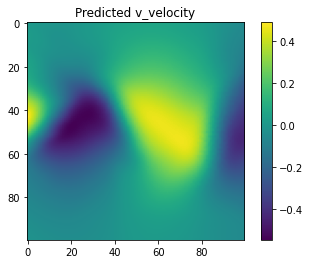

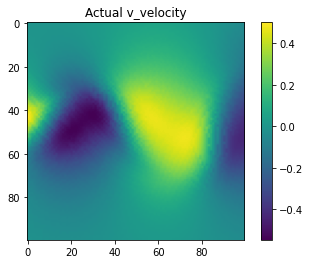

Errors at timestep: [1.]
------------------------------------------------
Error u: 1.909367e-02
Error v: 8.071755e-02
Error p: 2.899308e+00


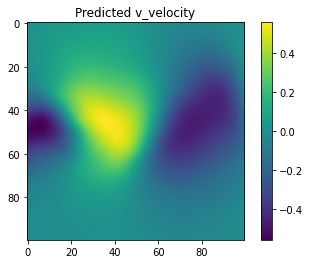

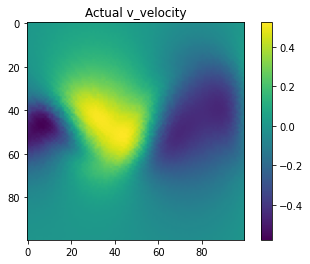

Errors at timestep: [2.]
------------------------------------------------
Error u: 1.711176e-02
Error v: 7.752481e-02
Error p: 5.641785e+00


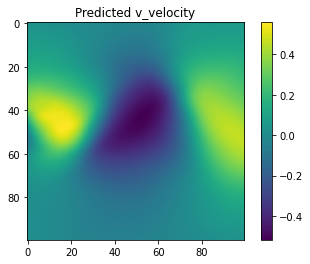

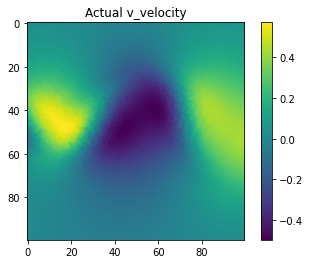

Errors at timestep: [3.]
------------------------------------------------
Error u: 1.708689e-02
Error v: 7.471022e-02
Error p: 2.272302e+00


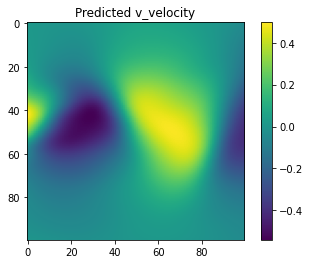

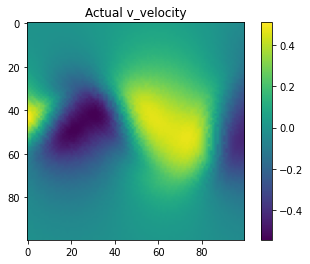

Errors at timestep: [4.]
------------------------------------------------
Error u: 1.521060e-02
Error v: 6.058200e-02
Error p: 2.752390e+00


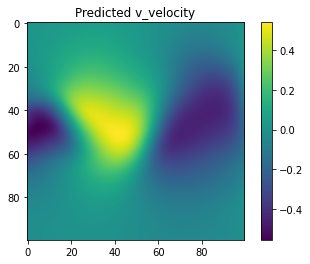

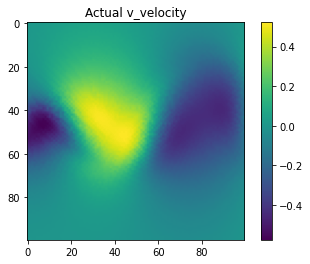

Errors at timestep: [5.]
------------------------------------------------
Error u: 1.460097e-02
Error v: 5.308062e-02
Error p: 1.505694e+00


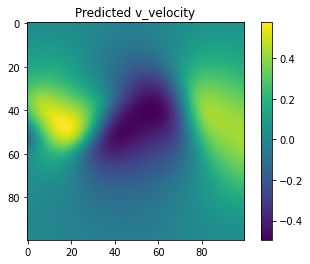

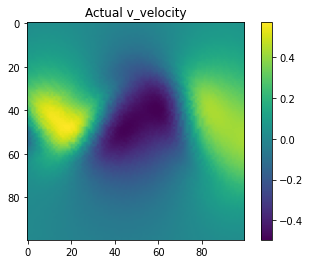

Errors at timestep: [6.]
------------------------------------------------
Error u: 1.453251e-02
Error v: 6.637325e-02
Error p: 3.234035e-01


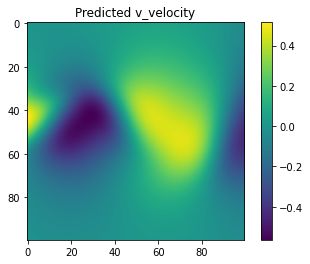

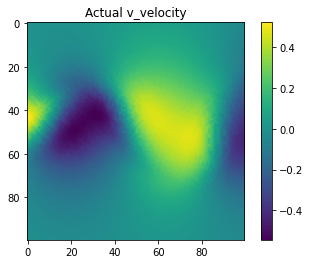

Errors at timestep: [7.]
------------------------------------------------
Error u: 1.446415e-02
Error v: 4.851704e-02
Error p: 2.055610e-01


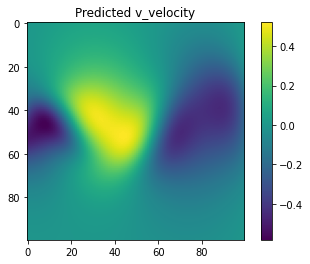

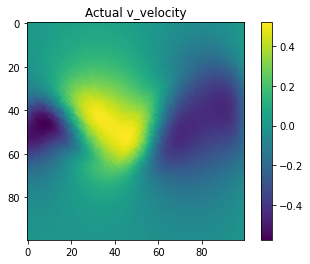

In [16]:
eu=[]
ev=[]
for i in np.arange(0,8,1):
    eua,eva=test_check_predictions(round(i,3),bc_pinn_model_test,plot=True)
    eu.append(eua)
    ev.append(eva)

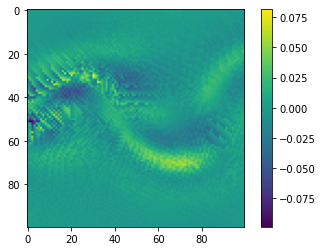

In [28]:
X_star,Y_star=load_testdata(6)
u_pred, v_pred, p_pred = bc_pinn_model_test.predict(X_star[0],X_star[1],X_star[2])
err=u_pred-Y_star[0]
err=np.reshape(err,(100,100))

plt.imshow(err)
plt.colorbar()


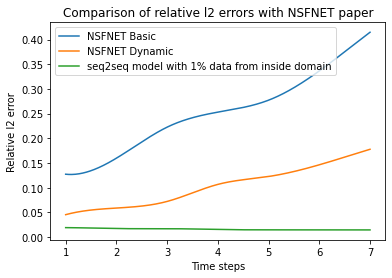

In [17]:
from scipy.interpolate import make_interp_spline as mis

nsfdata=pd.read_csv(r"C:\Users\user1\Desktop\NSFNET_basic.csv").to_numpy()
nsfdata2=pd.read_csv(r"C:\Users\user1\Desktop\NSFNET_dynamic.csv").to_numpy()
for i in range(nsfdata.shape[1]):
    nsfdata[i,0]=round(nsfdata[i,0],3)
    
for i in range(nsfdata2.shape[1]):
    nsfdata2[i,0]=round(nsfdata2[i,0],3)

t_nsf=nsfdata[:,0]
eu_nsf=nsfdata[:,1]
eu_nsf2=nsfdata2[:,1]

# Basic 
xyspline=mis(t_nsf,eu_nsf)
x=np.linspace(t_nsf.min(),t_nsf.max(),500)
y=xyspline(x)
plt.plot(x,y)
# Dynamic weights
xyspline3=mis(t_nsf,eu_nsf2)
y3=xyspline3(x)
plt.plot(x,y3)

# MY model
t=[i for i in np.arange(0,8,1)]
xyspline2=mis(t,eu)
y2=xyspline2(x)
plt.plot(x,y2)

plt.legend(['NSFNET Basic','NSFNET Dynamic','seq2seq model with 1% data from inside domain'])
plt.title("Comparison of relative l2 errors with NSFNET paper")
plt.xlabel("Time steps")
plt.ylabel("Relative l2 error")
plt.show()

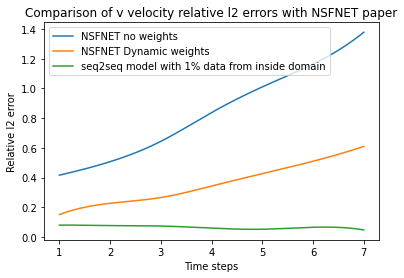

In [18]:
from scipy.interpolate import make_interp_spline as mis

nsfdatav=pd.read_csv(r"C:\Users\user1\Desktop\vvel_basic.csv").to_numpy()
nsfdatav2=pd.read_csv(r"C:\Users\user1\Desktop\vvel_dynamic.csv").to_numpy()
for i in range(nsfdatav.shape[1]):
    nsfdatav[i,0]=round(nsfdatav[i,0],3)
    
for i in range(nsfdatav2.shape[1]):
    nsfdatav2[i,0]=round(nsfdatav2[i,0],3)

t_nsf=nsfdatav[:,0]
eu_nsf=nsfdatav[:,1]
eu_nsf2=nsfdatav2[:,1]

# Basic 
xyspline=mis(t_nsf,eu_nsf)
x=np.linspace(t_nsf.min(),t_nsf.max(),500)
y=xyspline(x)
plt.plot(x,y)
# Dynamic weights
xyspline3=mis(t_nsf,eu_nsf2)
y3=xyspline3(x)
plt.plot(x,y3)

# MY model
t=[i for i in np.arange(0,8,1)]
xyspline2=mis(t,ev)
y2=xyspline2(x)
plt.plot(x,y2)

plt.legend(['NSFNET no weights','NSFNET Dynamic weights','seq2seq model with 1% data from inside domain'])
plt.title("Comparison of v velocity relative l2 errors with NSFNET paper")
plt.xlabel("Time steps")
plt.ylabel("Relative l2 error")
plt.show()

# Run this code segment to save the errors


In [17]:
def save_error_data(file_name,eu):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\RE100_mts_results\novel_method")
    my_path=root_path/file_name

    with open(my_path,'wb') as f:
        pickle.dump(eu,f)
        print("Errors are saved in pickle file")


In [18]:
def load_error_data(file_name):
    root_path=Path(r"E:\Vamsi_oe20s302\Vamsi\seq2seq learning\Re100_mts_results\novel_method")
    my_path=root_path/file_name

    # returns the weights and biases of the network as np array
    with open(my_path,'rb') as f:
        eu_load=pickle.load(f)
    return eu_load

# Saving the errors

In [19]:
save_error_data('1data_long_training',eu)

Errors are saved in pickle file


# Comparing the reduced data models

In [24]:
eu10=load_error_data('10data')
euwd=load_error_data('withoutdata')
eu50=load_error_data('50data')
eu1=load_error_data('1data')

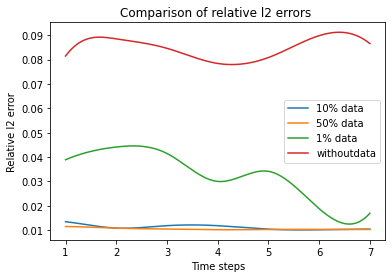

In [25]:

t=[i for i in np.arange(0,8,1)]

xyspline10=mis(t,eu10)
y10=xyspline10(x)
plt.plot(x,y10)

xyspline50=mis(t,eu50)
y50=xyspline50(x)
plt.plot(x,y50)

xyspline10re=mis(t,eu1)
y10re=xyspline10re(x)
plt.plot(x,y10re)

xysplinewd=mis(t,euwd)
ywd=xysplinewd(x)
plt.plot(x,ywd)

plt.legend(['10% data','50% data','1% data','withoutdata'])
plt.title("Comparison of relative l2 errors ")
plt.xlabel("Time steps")
plt.ylabel("Relative l2 error")
plt.show()

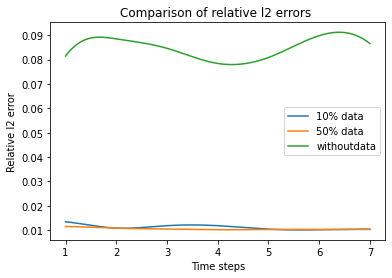

In [50]:
t=[i for i in np.arange(0,8,1)]

xyspline10=mis(t,eu10)
y10=xyspline10(x)
plt.plot(x,y10)

xyspline50=mis(t,eu50)
y50=xyspline50(x)
plt.plot(x,y50)

xysplinewd=mis(t,euwd)
ywd=xysplinewd(x)
plt.plot(x,ywd)

plt.legend(['10% data','50% data','withoutdata'])
plt.title("Comparison of relative l2 errors ")
plt.xlabel("Time steps")
plt.ylabel("Relative l2 error")
plt.show()